minion1016 WFD depth for 1yr (defined as all nights<night=365) vs. WFD depth for 10yr survey gives 4.8 times an improvement in flux, not sqrt(10)= 3.16, so something is wrong. 

Here, we compare the number of observations/nights in 1yr vs. 10yr data to see whats happening.

In [1]:
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as mafUtils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import healpy as hp
from collections import OrderedDict
import pandas as pd
from IPython.display import display
from copy import deepcopy
from scipy.stats import iqr

In [2]:
from os.path import expanduser
home = expanduser("~")
# simdata datapath
dbpath= home+'/lsstData/'
dbpath+='minion_1016_sqlite_new_dithers.db'   # new afterburner output

Access the WFD simdata for different years for all bands.

In [3]:
simdata= {}
opsdb = db.OpsimDatabase(dbpath)
propIds, propTags = opsdb.fetchPropInfo()
wfdWhere = mafUtils.createSQLWhere('WFD', propTags)

colnames = ['fieldID', 'expDate', 'night', 'obsHistID']
for yearCut in np.arange(1,10):
    nightCutOff= yearCut*365.25
    sqlconstraint  = wfdWhere + ' and night <= ' + str(nightCutOff)# + ' and filter=="' + filterBand + '"'
    simdata['%syr'%int(yearCut)] = opsdb.fetchMetricData(colnames, sqlconstraint)
    
sqlconstraint= wfdWhere #+ ' and filter=="' + filterBand + '"'
simdata['10yr'] = opsdb.fetchMetricData(colnames, sqlconstraint)

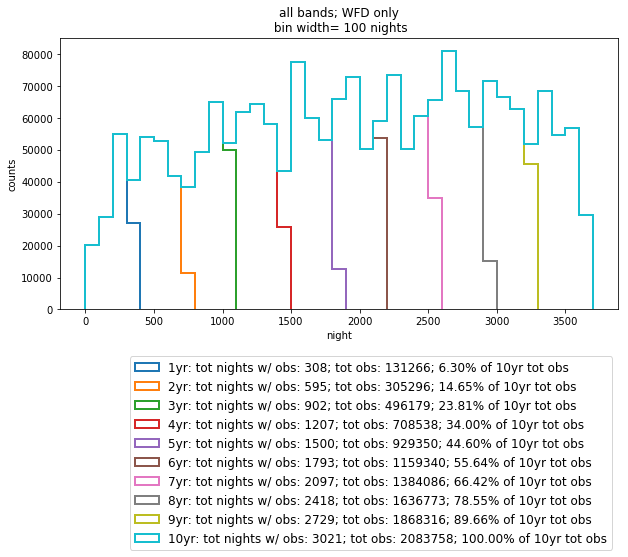

In [4]:
tot10YrObs= len(simdata['10yr']['night'])

plt.clf()
fig, axes= plt.subplots(1,1)
ax=axes
binwidth= 100
lw= 20
for yr in simdata.keys():
    lw= 2
    histtype= 'step'
        
    totNightsWithObs= len(np.unique(simdata[yr]['night']))
    label= '%s: tot nights w/ obs: %s; '%(yr, totNightsWithObs)
    label+= 'tot obs: %s; '%len(simdata[yr]['night'])
    label+= '%.2f%% of 10yr tot obs'%(100.*len(simdata[yr]['night'])/tot10YrObs)
                                                                                          
    counts, bins, eh= ax.hist(simdata[yr]['night'], histtype= histtype, lw= lw, 
                              label= label, #alpha= 0.6, 
                              bins=range(min(simdata[yr]['night']), max(simdata[yr]['night']) + binwidth, binwidth)
                              )
plt.title('all bands; WFD only\n bin width= %s nights'%(binwidth))
ax.set_xlabel('night')
ax.set_ylabel('counts')
ax.legend(bbox_to_anchor=(1.,-0.15), fontsize= 12)
plt.gcf().set_size_inches(10, 5)
plt.show()

Ok so we have only 6.3% (not 10%) of visits in the first year. Why? Check the full (WFD+DDFs) survey.

Read in the data for WFD+DDFs.

In [5]:
opsdb = db.OpsimDatabase(dbpath)
simdata_all= {}
colnames = ['fieldID', 'expDate', 'night', 'obsHistID']
for yearCut in np.arange(1,10):
    nightCutOff= yearCut*365.25
    sqlconstraint  = 'night <= ' + str(nightCutOff)
    simdata_all['%syr'%int(yearCut)] = opsdb.fetchMetricData(colnames, sqlconstraint)
    
sqlconstraint= ''
simdata_all['10yr'] = opsdb.fetchMetricData(colnames, sqlconstraint)

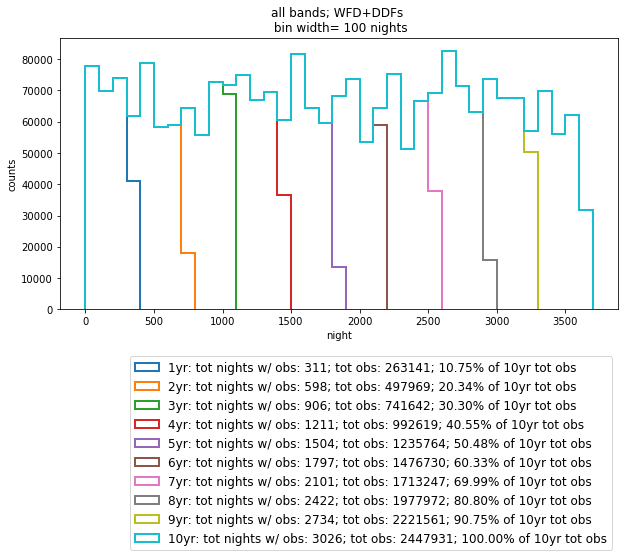

In [6]:
tot10YrObs= len(simdata_all['10yr']['night'])

plt.clf()
fig, axes= plt.subplots(1,1)
ax=axes
binwidth= 100
lw= 20
for yr in simdata_all.keys():
    lw= 2
    histtype= 'step'
        
    totNightsWithObs= len(np.unique(simdata_all[yr]['night']))
    label= '%s: tot nights w/ obs: %s; '%(yr, totNightsWithObs)
    label+= 'tot obs: %s; '%len(simdata_all[yr]['night'])
    label+= '%.2f%% of 10yr tot obs'%(100.*len(simdata_all[yr]['night'])/tot10YrObs)
                                                                                          
    counts, bins, eh= ax.hist(simdata_all[yr]['night'], histtype= histtype, lw= lw, 
                              label= label,
                              bins=range(min(simdata_all[yr]['night']), max(simdata_all[yr]['night']) + binwidth, binwidth)
                              )
plt.title('all bands; WFD+DDFs \n bin width= %s nights'%(binwidth))
ax.set_xlabel('night')
ax.set_ylabel('counts')
ax.legend(bbox_to_anchor=(1.,-0.15), fontsize= 12)
plt.gcf().set_size_inches(10, 5)
plt.show()

Ok so WFD+DDFs numbers make more sense: 1yr does have 10% of total visits. 

#### So DDFs are more strongly prefered in the first year in minion1016, hence fewer than 10% visits for 1yr in WFD.

##### Find the night by which number of visits= 10% of total 10yr visits

In [7]:
for yr in list(simdata.keys())[0:2]:
    print('%s: tot obs: %s '%(yr, len(simdata[yr]['night'])))
    print('%.2f%% of 10yr tot obs\n'%(100.*len(simdata[yr]['night'])/tot10YrObs))

1yr: tot obs: 131266 
5.36% of 10yr tot obs

2yr: tot obs: 305296 
12.47% of 10yr tot obs



In [8]:
for night in np.unique(simdata['2yr']['night']):
    ind= np.where(simdata['2yr']['night']==night)[0] ## all the obs on night
    ind= max(ind)  # last observation on this night
    #print(ind)
    percentObs= 100.*len(simdata[yr]['night'][0:ind])/tot10YrObs
    if (percentObs>9.9) and (percentObs<10.1):
        print('Upto night= ', night)
        print('%.2f%% of 10yr tot obs\n'%(percentObs))
        

Upto night=  582
9.93% of 10yr tot obs

Upto night=  583
9.97% of 10yr tot obs

Upto night=  584
10.01% of 10yr tot obs

Upto night=  585
10.04% of 10yr tot obs

Upto night=  586
10.08% of 10yr tot obs



#### Ok so the 1yr data technically should have the median depth achieved by night= 521 (by which have 10% of WFD total observations).

In [9]:
# just a quick check
print(max(simdata['1yr']['night']))

365
